# instalacion Spark

In [ ]:
from bs4 import BeautifulSoup
import requests
url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
print(spark_link)


['spark-2.4.8/', 'spark-3.0.3/', 'spark-3.1.2/', 'spark-3.1.3/', 'spark-3.2.1/']


In [ ]:
ver_spark = spark_link[1][:-1] 
print(ver_spark)

spark-3.0.3


In [ ]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.system(f"wget -q {url+ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")
!ls

drive	     spark-3.0.3-bin-hadoop2.7	    spark-3.0.3-bin-hadoop2.7.tgz.1
sample_data  spark-3.0.3-bin-hadoop2.7.tgz  sparkdltrigger.web.cern.ch


In [ ]:
!pip install -q pyspark
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop2.7"

In [ ]:
!ls

drive	     spark-3.0.3-bin-hadoop2.7	    spark-3.0.3-bin-hadoop2.7.tgz.1
sample_data  spark-3.0.3-bin-hadoop2.7.tgz  sparkdltrigger.web.cern.ch


In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config("spark.driver.memory","12g") \
        .config("spark.sql.execution.arrow.enabled","true") \
        .getOrCreate()

In [ ]:
spark

# Code

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('default')
%matplotlib inline

## Cargar data

In [ ]:

DATASET_NAME="testUndersampled_HLF_features.parquet"
!wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME

DATASET_NAME="trainUndersampled_HLF_features.parquet"
!wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME

--2022-06-12 23:35:12--  http://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 188.185.87.216, 188.185.90.87, 137.138.31.235
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|188.185.87.216|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet [following]
--2022-06-12 23:35:13--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|188.185.87.216|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet/ [following]
--2022-06-12 23:35:14--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/testUndersampled_HLF_features.parquet/
Reusin

In [ ]:
PATH = "/content/sparkdltrigger.web.cern.ch/sparkdltrigger/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [ ]:
num_test = testDF.count()
num_train = trainDF.count()

print(f"There are {num_test} events in the test dataset")
print(f"There are {num_train} events in the train dataset")

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


## Toma un subconjunto de los datos

In [ ]:
fraction=0.02 # 2%

trainDF_fraction = trainDF.sample(fraction=fraction, seed=42)
testDF_fraction = testDF.sample(fraction=fraction, seed=42)

In [ ]:
num_test = testDF_fraction.count()
num_train = trainDF_fraction.count()

print(f"trainDF_fraction tiene {num_test} eventos")
print(f"testDF_fraction tiene {num_train} eventos")

trainDF_fraction tiene 17391 eventos
testDF_fraction tiene 68959 eventos


In [ ]:
trainDF = trainDF_fraction.toPandas()
testDF = testDF_fraction.toPandas()

In [ ]:
trainDF.head()

,HLF_input,encoded_label
0,"[0.009693230742408777, 0.0021876673224971144, ...","[0.0, 0.0, 1.0]"
1,"[0.007835843825668067, 0.0053547365449537285, ...","[0.0, 0.0, 1.0]"
2,"[0.0111168793424784, 0.019656097803980376, 0.3...","[0.0, 1.0, 0.0]"
3,"[0.0076220352772453145, 0.002450788727385921, ...","[1.0, 0.0, 0.0]"
4,"[0.012901241911141129, 0.003373984267211007, 0...","[1.0, 0.0, 0.0]"


In [ ]:
trainDF[trainDF.columns] = trainDF[trainDF.columns].applymap(lambda x: list(x))
testDF[testDF.columns] = testDF[testDF.columns].applymap(lambda x: list(x))

In [ ]:
import numpy as np

X = np.array(trainDF['HLF_input'].tolist())
y = np.array(trainDF['encoded_label'].tolist())

X_test = np.array(testDF['HLF_input'].tolist())
y_test = np.array(testDF['encoded_label'].tolist())

## Modelo en keras

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Prueba del modelo

In [ ]:
baseline = create_model(50,20,10)

history = baseline.fit(X, y, batch_size=64, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1078/1078 [==============================] - 4s 3ms/step - loss: 0.4678 - accuracy: 0.8233 - val_loss: 0.3563 - val_accuracy: 0.8668
Epoch 2/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.3530 - accuracy: 0.8689 - val_loss: 0.3301 - val_accuracy: 0.8763
Epoch 3/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.3257 - accuracy: 0.8804 - val_loss: 0.3028 - val_accuracy: 0.8889
Epoch 4/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.3036 - accuracy: 0.8903 - val_loss: 0.2992 - val_accuracy: 0.8943
Epoch 5/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.2938 - accuracy: 0.8935 - val_loss: 0.2832 - val_accuracy: 0.8979
Epoch 6/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.2881 - accuracy: 0.8962 - val_loss: 0.2841 - val_accuracy: 0.8962
Epoch 7/50
1078/1078 [==============================] - 3s 3ms/step - loss: 0.2837 - accuracy: 0.8969 - val_loss: 0.2808 - val_accuracy:

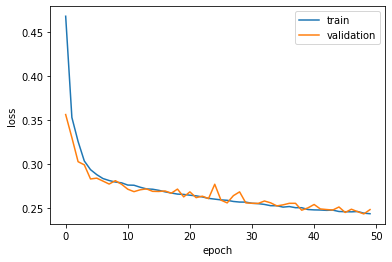

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

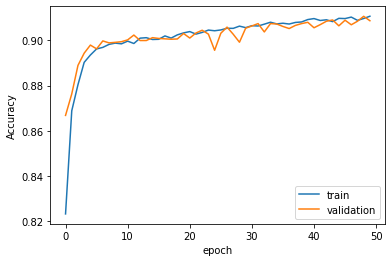

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix

In [ ]:
y_pred=history.model.predict(X_test)
y_true=y_test

In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


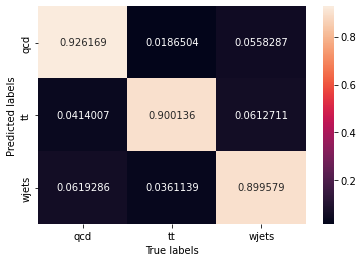

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Crear clasificador keras

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


### Definir hyperparametros 

In [ ]:
batch_size = [64, 100,200]
epochs = [10, 30, 50]

nh_1 = [50,100,150]
nh_2 = [20,50,100]
nh_3 = [10,20,50]

In [ ]:
param_grid = {'batch_size':batch_size,
              'nb_epoch':epochs,
              'nh_1':nh_1, 'nh_2':nh_2, 'nh_3':nh_3}

### Busqueda de hiperparametros

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV( estimator=model, param_grid=param_grid, cv=10, verbose=1)

In [ ]:
gridSearch_result = grid.fit(X, y)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:428: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = (n_samples // n_splits) * np.ones(n_splits, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/

In [ ]:
gridSearch_result.best_estimator_.get_params()

{'batch_size': 64,
 'build_fn': <function __main__.create_model>,
 'nb_epoch': 50,
 'nh_1': 150,
 'nh_2': 20,
 'nh_3': 50,
 'verbose': 0}

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.9841992278637517, 1: 0.9845079303878103, 2: 0.9783751699324114}

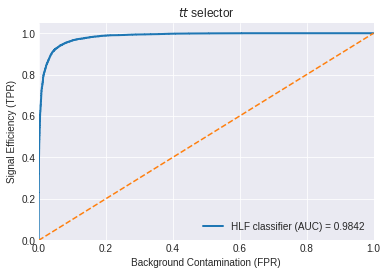

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()